In [1]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import cv2
import argparse
import glob
import itertools

In [2]:
def camera_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # (8,6) is for the given testing images.
    # If you use the another data (e.g. pictures you take by your smartphone),
    # you need to set the corresponding numbers.
    corner_x = 7
    corner_y = 7
    objp = np.zeros((corner_x * corner_y, 3), np.float32)
    objp[:, :2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # points on object plane
    imgpoints = []  # points in image plane.

    # Make a list of calibration images
    # images = glob.glob('data/*.jpg')
    images = glob.glob(CHECKERBOARDS_PATH + "*.jpeg")

    # Step through the list and search for chessboard corners
    print("Start finding chessboard corners...")
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # rotate the image with it is horizontal (default verticle)
        if img.shape[1] - img.shape[0] >= 0:
            print(fname, " need rotation")
            gray = np.rot90(gray)

        # Find the chessboard corners
        print("find the chessboard corners of", fname)
        ret, corners = cv2.findChessboardCorners(
            gray, (corner_x, corner_y), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)  # points on object plane
            imgpoints.append(corners)  # points on image plane

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (corner_x, corner_y), corners, ret)

    print("Camera calibration...")
    img_size = (img.shape[1], img.shape[0])
    # You need to comment these functions and write your calibration function from scratch.
    # Notice that rvecs is rotation vector, not the rotation matrix, and tvecs is translation vector.
    # In practice, you'll derive extrinsics matrixes directly. The shape must be [pts_num,3,4], and use them to plot.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_size, None, None)

    return mtx


def read_intrinsic():
    if args.img == "Mesona":
        K1 = np.array([1.4219, 0.0005, 0.509, 0, 1.4219, 0.3802, 0, 0, 0.001])
        K2 = K1
    elif args.img == "Statue":
        K1 = np.array(
            [5426.566895, 0.678017, 330.096680, 0.000000,
                5423.133301, 648.950012, 0.000000, 0.000000, 1.000000]
        )
        K2 = np.array(
            [5426.566895, 0.678017, 387.430023, 0.000000,
                5423.133301, 620.616699, 0.000000, 0.000000, 1.000000]
        )
    elif args.img == "books":
        intrinsic = camera_calibration()
        K1 = intrinsic
        K2 = intrinsic

    # The last element should be 1 and reshape to (3,3)
    K1 = K1.reshape((3, 3))
    K1 /= K1[2, 2]

    K2 = K2.reshape((3, 3))
    K2 /= K2[2, 2]

    return K1, K2


def detect_interest_p(img):
    feat_type = cv2.xfeatures2d.SIFT_create()#cv2.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    p, desc = feat_type.detectAndCompute(gray, None)
    return p, desc


class DMatch:
    def __init__(self, distance, trainIdx, queryIdx):
        self.distance = distance
        self.trainIdx = int(trainIdx)
        self.queryIdx = int(queryIdx)
        self.imgIdx = 0


def get_ratio_matches(desc1, desc2):
    dist = cdist(desc1, desc2, metric="euclidean")
    matches = np.empty((desc1.shape[0], 2), dtype=object)
    for i in range(desc1.shape[0]):
        idx = [j for j in range(desc2.shape[0])]
        dist_array = np.array(list(zip(dist[i, :], idx)))
        sorted_dist = dist_array[np.argsort(dist_array[:, 0])]
        for j in range(2):
            matches[i, j] = DMatch(sorted_dist[j, 0], i, sorted_dist[j, 1])

    return matches


def get_good_matches(matches):
    # ration test
    good_matches = []
    for a, b in matches:
        if a.distance < args.ratio * b.distance:
            good_matches.append(a)
    return good_matches


def draw_matching(kp1, kp2, img1, img2):
    match_img = np.concatenate((img1, img2), axis=1)  # output matching image
    h1, w1, c1 = img1.shape
    for i in range(kp1.shape[0]):
        # locate matching point
        color = list(np.random.random(size=3) * 256)
        coor1 = list(kp1[i])
        x1 = int(coor1[0])
        y1 = int(coor1[1])
        coor2 = list(kp2[i])
        x2 = w1 + int(coor2[0])
        y2 = int(coor2[1])

        # draw circle on matching points and line between them
        match_img = cv2.circle(match_img, (x1, y1), 3, color, 3)
        match_img = cv2.circle(match_img, (x2, y2), 3, color, 3)
        match_img = cv2.line(match_img, (x1, y1), (x2, y2), color, 1)

    return match_img


def find_correspondence(img1, img2):
    # get interest points
    p1, desc1 = detect_interest_p(img1)
    p2, desc2 = detect_interest_p(img2)
    # feature matching
    matches = get_ratio_matches(desc1, desc2)
    good_matches = get_good_matches(matches)
    # store the matching keypoints
    kp1 = np.empty(len(good_matches), dtype=tuple)
    kp2 = np.empty(len(good_matches), dtype=tuple)
    correspondence = np.zeros((len(good_matches), 4), dtype=float)
    for i, match in enumerate(good_matches):
        kp1[i] = p1[match.trainIdx].pt
        kp2[i] = p2[match.queryIdx].pt
        correspondence[i, :] = [kp1[i][0], kp1[i][1], kp2[i][0], kp2[i][1]]

    # draw feature matching
    match_img = draw_matching(kp1, kp2, img1, img2)
    match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 10))
    plt.imshow(match_img)
    plt.axis("off")
    plt.savefig(SAVE_PATH + args.img + "_feature_matching.jpg")
    plt.show()

    return correspondence


def get_normalize_x_x_prime(correspondence, rand_choice):
    # get x,x' and normalize to [0,1]
    # https://www.csie.ntu.edu.tw/~cyy/courses/vfx/20spring/lectures/handouts/lec10_sfm.pdf
    x = np.zeros((8, 2), dtype=float)
    x_prime = np.zeros((8, 2), dtype=float)

    x = correspondence[rand_choice, :2]
    x_prime = correspondence[rand_choice, 2:]
    one_vec = np.ones(8)
    one_vec = one_vec.reshape(-1, 1)
    x = np.hstack((x, one_vec))
    x = x.T
    x_prime = np.hstack((x_prime, one_vec))
    x_prime = x_prime.T

    # normalize x
    x_mean = np.mean(x, axis=1)
    S = np.sqrt(2) / np.std(x[:2])
    T = np.array([[S, 0, -S * x_mean[0]], [0, S, -S * x_mean[1]], [0, 0, 1]])
    x = T @ x

    # normalize x'
    x_prime_mean = np.mean(x_prime, axis=1)
    S_prime = np.sqrt(2) / np.std(x_prime[:2])
    T_prime = np.array([[S_prime, 0, -S_prime * x_prime_mean[0]],
                       [0, S_prime, -S_prime * x_prime_mean[1]], [0, 0, 1]])
    x_prime = T_prime @ x_prime
    x = x.T
    x_prime = x_prime.T

    return x, x_prime, T, T_prime


def eight_p_algorithm(x, x_prime, T, T_prime):
    # build the constraint matrix
    A = np.zeros((8, 9), dtype=float)
    for i in range(8):
        A[i] = [
            x[i, 0] * x_prime[i, 0],
            x[i, 0] * x_prime[i, 1],
            x[i, 0],
            x[i, 1] * x_prime[i, 0],
            x[i, 1] * x_prime[i, 1],
            x[i, 1],
            x_prime[i, 0],
            x_prime[i, 1],
            1,
        ]

    # extract the fundamental matrix from the column of V corresponding to the smallest singular value
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape((3, 3))
    
    # enforce rank 2 constraint
    U, D, V = np.linalg.svd(F)
    D[2] = 0
    F = U @ (np.diag(D) @ V)
    F /= F[-1, -1]

    # denormalize
    F = T.T @ F @ T_prime
    F /= F[2, 2]

    return F


def Sampson_err(correspondence, F):
    x1 = correspondence[:, :2]
    x2 = correspondence[:, 2:]
    one_vec = np.ones((correspondence.shape[0], 1))
    x1 = np.hstack((x1, one_vec))
    x2 = np.hstack((x2, one_vec))

    Fx1 = F @ x1.T
    Fx2 = F @ x2.T
    denom = Fx1[0] ** 2 + Fx1[1] ** 2 + Fx2[0] ** 2 + Fx2[1] ** 2
    err = (np.diag(x1 @ (F @ x2.T))) ** 2 / denom

    return err


def estimate_fundamental_mat(correspondence):
    max_inlier = 0
    best_F = np.zeros((3, 3), dtype=float)

    for i in range(args.iter):
        rand_choice = list(np.random.random(size=8) * correspondence.shape[0])
        rand_choice = list(map(int, rand_choice))
        x, x_prime, T, T_prime = get_normalize_x_x_prime(
            correspondence, rand_choice)
        F = eight_p_algorithm(x, x_prime, T, T_prime)
        errors = Sampson_err(correspondence, F)
        inlier = 0
        for error in errors:
            if error < args.threshold:
                inlier += 1
        if inlier > max_inlier:
            max_inlier = inlier
            best_F = F
    print(f"Max inliers: {max_inlier}")

    return best_F


def select_inliers(correspondence, F):
    errors = Sampson_err(correspondence, F)
    pts1 = []
    pts2 = []
    for i, error in enumerate(errors):
        if error < args.threshold:
            pts1.append(correspondence[i, :2])
            pts2.append(correspondence[i, 2:])
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    return pts1, pts2


def draw_epipolar_line(img1, img2, correspondence, F):
    pts1, pts2 = select_inliers(correspondence, F)
    h, w, c = img1.shape
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape((-1, 1, 2)), 2, F)
    lines1 = lines1.reshape((-1, 3))
    for h, pt1, pt2 in zip(lines1, pts1, pts2):
        color = list(np.random.random(size=3) * 256)
        pt1 = tuple(map(int, pt1))
        pt2 = tuple(map(int, pt2))
        x0, y0 = map(int, [0, -h[2] / h[1]])
        x1, y1 = map(int, [w, -(h[2] + h[0] * w) / h[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 3, color, 3)
        img2 = cv2.circle(img2, tuple(pt2), 3, color, 3)

    epipole_img = np.concatenate((img1, img2), axis=1)
    epipole_img = cv2.cvtColor(epipole_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 10))
    plt.imshow(epipole_img)
    plt.axis("off")
    plt.savefig(SAVE_PATH + args.img + "_epipolar_line.jpg")
    plt.show()


def select_img():
    if args.img == "Mesona":
        img1_name = "Mesona1.JPG"
        img2_name = "Mesona2.JPG"
    elif args.img == "Statue":
        img1_name = "Statue1.bmp"
        img2_name = "Statue2.bmp"
    elif args.img == "books":
        img1_name = "books1.jpg"
        img2_name = "books2.jpg"

    return img1_name, img2_name



In [3]:
def triangulation(x, x_prime, P, P_prime):
    A = np.array([
        x[0]*P[2,:]- P[0,:],
        x[1]*P[2,:]- P[1,:],
        x_prime[0]*P_prime[2,:]- P_prime[0,:],
        x_prime[1]*P_prime[2,:]- P_prime[1,:]
    ])
    U, S, V = np.linalg.svd(A)
    #print("this should be close to zero vec: ", A.dot(V[-1,:]))
    return V[-1 ,:]

In [4]:
def decompose_essential(E, correspondence):
    W = np.array([[0,-1, 0],
                  [1, 0, 0],
                  [0, 0, 1]
    ])
    
    W_inv = np.array([[ 0, 1, 0],
                      [-1, 0, 0],
                      [ 0, 0, 1]
    ])
    
    U, L, V = np.linalg.svd(E)
    #print(U,L,V)
    print("check that essential matrix is well formed (rank = 2) : ", L)
    Cross_mat = U @ np.diag(L) @ W @ U.T
    print(Cross_mat)
    trans_v = U[-1]
    trans_v = trans_v / np.linalg.norm(trans_v)
    rotate_m1 = U @ W_inv @ V.T
    rotate_m2 = U @ W_inv.T @ V.T
    
    inliers_record = dict()
    best_inlier_cnt = -1
    for r,t in itertools.product([rotate_m1, rotate_m2],[trans_v, -trans_v]):
        P2 = K2 @ np.hstack([r,t.reshape(3,1)])
        P1 = K1 @ np.hstack([np.eye(3),np.zeros(shape=(3,1))])
        print(P1.shape)
        inliers_cnt = 0
        # find out the best choice of P
        for cor in correspondence:
            x1 = cor[0:2]
            x2 = cor[2:]
            X = triangulation(x1,x2,P1,P2)
            X = X / X[3]
            X = X[0:3]
            #print(X[2] / np.linalg.norm(X))
            #print((X - t).dot(r[2,:]) / np.linalg.norm( X - t ) )
            in_front_of_camera_1 = X[2] / np.linalg.norm(X) > 0.5
            in_front_of_camera_2 = (X - t).dot(r[2,:]) / np.linalg.norm( X - t ) > 0.5
            if in_front_of_camera_1 and in_front_of_camera_2:
                inliers_cnt += 1
        print(f'inlier for (r,t) = {(r,t)}: {inliers_cnt}')
        if inliers_cnt > best_inlier_cnt:
            best_rt = (r,t)
            best_inlier_cnt = inliers_cnt
    return best_rt[1], best_rt[0] 
        

In [5]:
class arguments:
    img: str
    ratio: float
    iter: int
    threshold : float
    def __init__(self, img, ratio=0.4, iter=1000, threshold=0.025):
        self.img = img
        self.ratio = ratio
        self.iter = iter
        self.threshold = threshold
args = arguments("books",ratio=0.3, iter=1000, threshold=0.0025)
#args = arguments("Statue",ratio=0.4, iter=1000, threshold=0.025)
#args = arguments("Mesona",ratio=0.3, iter=2000, threshold=0.3)

Start finding chessboard corners...
find the chessboard corners of ./checkerboards\checkerboards1.jpeg
find the chessboard corners of ./checkerboards\checkerboards2.jpeg
find the chessboard corners of ./checkerboards\checkerboards3.jpeg
find the chessboard corners of ./checkerboards\checkerboards4.jpeg
find the chessboard corners of ./checkerboards\checkerboards5.jpeg
find the chessboard corners of ./checkerboards\checkerboards6.jpeg
Camera calibration...
Intrinsic matrix of K1:
[[3.18483349e+03 0.00000000e+00 1.52193978e+03]
 [0.00000000e+00 3.17834870e+03 1.95540877e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Intrinsic matrix of K2:
[[3.18483349e+03 0.00000000e+00 1.52193978e+03]
 [0.00000000e+00 3.17834870e+03 1.95540877e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]



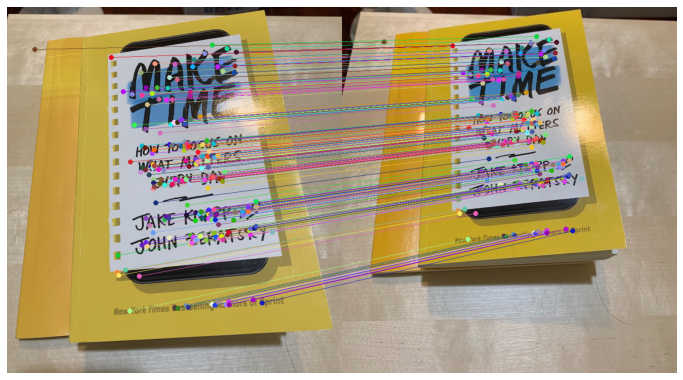

Number of correspondence: 226
Max inliers: 83

Fundamental matrix:
[[ 5.56118628e-07 -9.15459977e-05  1.11362552e-02]
 [ 8.79422614e-05  1.65866328e-06 -3.80814180e-02]
 [-1.41966191e-02  4.11567413e-02  1.00000000e+00]]


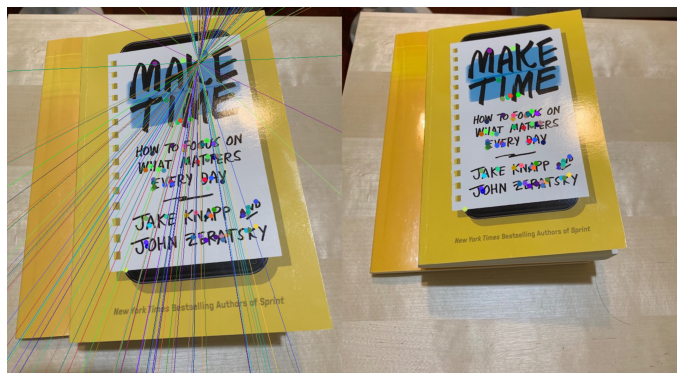

In [6]:
DATA_PATH = "./data/"
SAVE_PATH = "./results/"
CHECKERBOARDS_PATH = "./checkerboards/"
img1_name, img2_name = select_img()
img1 = cv2.imread(DATA_PATH + img1_name)
img2 = cv2.imread(DATA_PATH + img2_name)
K1, K2 = read_intrinsic()
print("Intrinsic matrix of K1:")
print(K1)
print("")
print("Intrinsic matrix of K2:")
print(K2)
print("")
correspondence = find_correspondence(img1, img2)
print(f"Number of correspondence: {correspondence.shape[0]}")
F = estimate_fundamental_mat(correspondence)
print("")
print("Fundamental matrix:")
print(F)
draw_epipolar_line(img1, img2, correspondence, F)

In [7]:
# calculate essential matrix from intrinsic and fundamental matrix
E = K2.T @ F @ K1

In [8]:
E

array([[ 5.64080265e+00, -9.26675404e+02, -5.31953859e+02],
       [ 8.90196543e+02,  1.67556514e+01,  3.14671690e+02],
       [ 5.05155449e+02, -3.01712345e+02, -7.38704759e-01]])

In [9]:
# decompose essential matrix into rotation_mat and translation
trans1_v, rotate1_m = np.zeros(shape=(3,)) ,np.eye(3)
trans2_v, rotate2_m = decompose_essential(E,correspondence)
print(trans2_v)
print(rotate2_m)

check that essential matrix is well formed (rank = 2) :  [1.11441740e+03 1.06666289e+03 3.04224193e-14]
[[  -6.89602541 -929.15254933 -527.60024299]
 [ 893.24688756   10.98067714  306.16716244]
 [ 502.66995674 -305.80899736   -4.08465173]]
(3, 4)
inlier for (r,t) = (array([[-0.62236883, -0.4460277 , -0.64320785],
       [ 0.59769823, -0.80140236, -0.02260715],
       [-0.50538487, -0.39851417,  0.76535781]]), array([0.16302437, 0.52467222, 0.83554899])): 0
(3, 4)
inlier for (r,t) = (array([[-0.62236883, -0.4460277 , -0.64320785],
       [ 0.59769823, -0.80140236, -0.02260715],
       [-0.50538487, -0.39851417,  0.76535781]]), array([-0.16302437, -0.52467222, -0.83554899])): 226
(3, 4)
inlier for (r,t) = (array([[ 0.9197766 ,  0.3502217 ,  0.17707559],
       [-0.09700819,  0.64011165, -0.76213285],
       [-0.38026361,  0.68381418,  0.62273409]]), array([0.16302437, 0.52467222, 0.83554899])): 0
(3, 4)
inlier for (r,t) = (array([[ 0.9197766 ,  0.3502217 ,  0.17707559],
       [-0.097008

In [10]:
P2 = K2 @ np.hstack([rotate2_m,trans2_v.reshape(3,-1)])
P1 = K1 @ np.hstack([rotate1_m,trans1_v.reshape(3,-1)])

points_3d = []
for ps in correspondence:
    p = triangulation(ps[0:2],ps[2:],P1,P2)
    points_3d.append(p[0:3]/p[3]) 
points_3d = np.array(points_3d)

(226, 3)


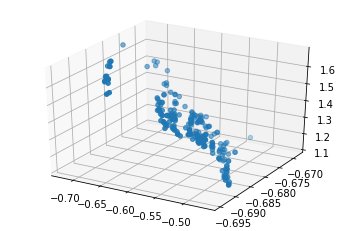

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
print(points_3d.shape)
ax.scatter(points_3d[:,0],points_3d[:,1],points_3d[:,2])
#ax.scatter(trans1_v[0],trans1_v[1],trans1_v[2])
#ax.scatter(trans2_v[0],trans2_v[1],trans2_v[2])

In [12]:
#%matplotlib inline
import ipyvolume as ipv
import numpy as np
import ipywidgets
import ipyvolume.pylab as p3
from IPython.display import display
from IPython.core.display import HTML
s = 10
mean = np.mean(points_3d,axis=0)
ps = (points_3d - mean)*s
ipv.quickscatter(ps[:,0],ps[:,1],ps[:,2],size=5, marker="sphere")
#p3.save('./3d.html')
#HTML(open('./3d.html').read())

In [13]:
points_3d = np.array(points_3d)
import matlab.engine
eng = matlab.engine.start_matlab()
p=matlab.double(P2.tolist())
d2=matlab.double(correspondence[:,0:2].tolist())
d3 = matlab.double(points_3d[:,0:3].tolist())
eng.obj_main(d3,d2,p, 'data/books1.jpg', 1 ,nargout=0)
#eng.obj_main(d3,d2,p, 'Statue1.bmp', 1 ,nargout=0)
#eng.obj_main(d3,d2,p, 'Mesona1.JPG', 1 ,nargout=0)